In [353]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


import scipy.stats as stats

In [354]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [355]:
df_vehiculos = pd.read_csv('./data/MotorAlpes_data.csv', sep=',', encoding = 'utf-8')

In [356]:
df_vehiculos.shape

(7115, 12)

In [357]:
df_vehiculos.sample(5)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
5768,6590,2016.0,11000.0,First Owner,Dealer,5.0,Petrol,Automatic,14.30,1598.0,103.50,7814.39
5288,6049,2009.0,141000.0,Second Owner,Individual,5.0,Petrol,Manual,19.70,796.0,46.30,1514.42
1246,1426,2009.0,90000.0,Second Owner,Individual,5.0,Diesel,Manual,18.10,1493.0,110.00,2544.22
6940,7929,2018.0,20000.0,First Owner,Individual,5.0,Petrol,Manual,20.14,1197.0,81.86,7753.82
6895,7880,2012.0,25000.0,First Owner,Individual,5.0,Petrol,Manual,21.10,NaN,NaN,3028.83


## 2.  Entendimiento y limpieza de los datos

Una variable que siempre tiene que estar es `Selling_price`, ya que la intención de este modelo es identificar las variables que impactar el precio de un vehiculo usado. Así como predecir el precio de un vehiculo a partir de esas varibles que afectan el precio.

Para esto solo se ha seleccionado variables numericas.

In [358]:
variables_interes = ['year', 'km_driven', 'seats', 'mileage', 'engine','max_power','transmission','fuel','seller_type','owner']

df_vehiculos_t = df_vehiculos.copy()

In [359]:
df_vehiculos_t[['selling_price'] + variables_interes].isnull().sum() / df_vehiculos_t.shape[0]

selling_price    0.056360
year             0.033591
km_driven        0.027829
seats            0.000000
mileage          0.027829
engine           0.039353
max_power        0.037667
transmission     0.000000
fuel             0.000000
seller_type      0.000000
owner            0.033591
dtype: float64

In [360]:
encoder = LabelEncoder()
df_vehiculos_t["owner"] = encoder.fit_transform(df_vehiculos_t["owner"])
print(encoder.classes_)
df_vehiculos_t["seller_type"] = encoder.fit_transform(df_vehiculos_t["seller_type"])
print(encoder.classes_)

df_vehiculos_t["fuel"] = encoder.fit_transform(df_vehiculos_t["fuel"])
print(encoder.classes_)

df_vehiculos_t["transmission"] = encoder.fit_transform(df_vehiculos_t["transmission"])
print(encoder.classes_)

df_vehiculos_t.sample(5)



['First Owner' 'Fourth & Above Owner' 'Second Owner' 'Test Drive Car'
 'Third Owner' nan]
['Dealer' 'Individual' 'Trustmark Dealer']
['CNG' 'Diesel' 'LPG' 'Petrol']
['Automatic' 'Manual']


,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
5489,6265,2016.0,49000.0,0,0,5.0,3,1,19.02,1198.0,67.05,3331.72
226,262,2015.0,50000.0,2,1,5.0,1,1,26.00,1498.0,98.60,8783.62
2357,2698,2019.0,30000.0,0,1,7.0,1,1,15.96,2523.0,62.10,8601.89
3232,3705,2017.0,80000.0,0,1,5.0,3,1,20.73,1373.0,91.10,9813.42
2393,2744,2017.0,31000.0,0,1,5.0,1,1,25.40,1186.0,73.97,7511.51


## 2.1 Relaciones entre variables
A continuación vamos a visualizar la correlación entre selling price y las variables de interes.

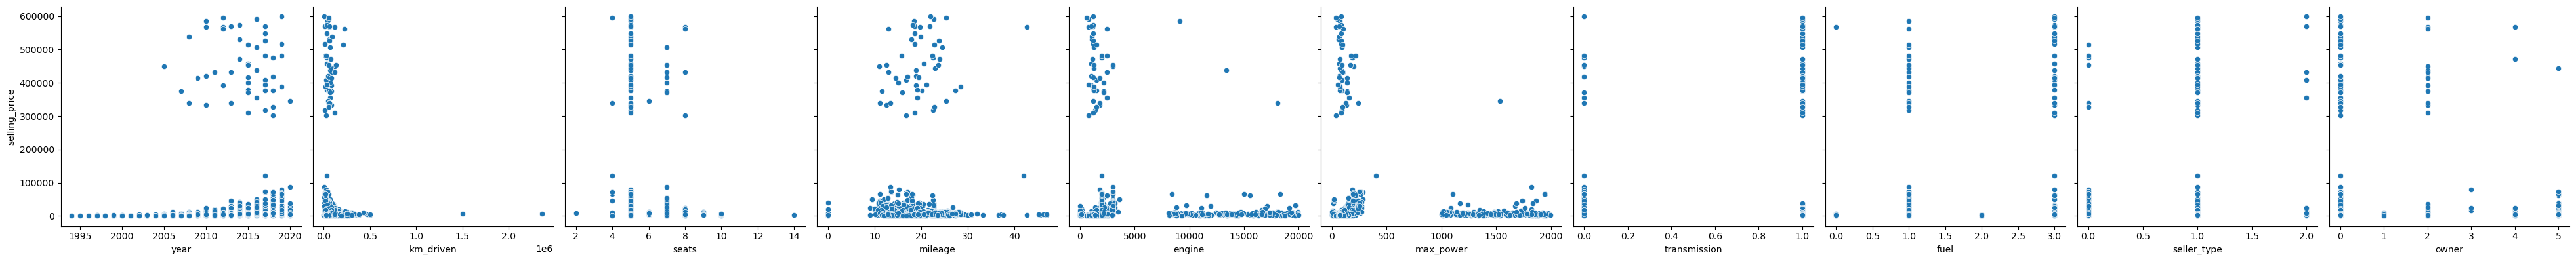

In [361]:
sns.pairplot(df_vehiculos_t, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

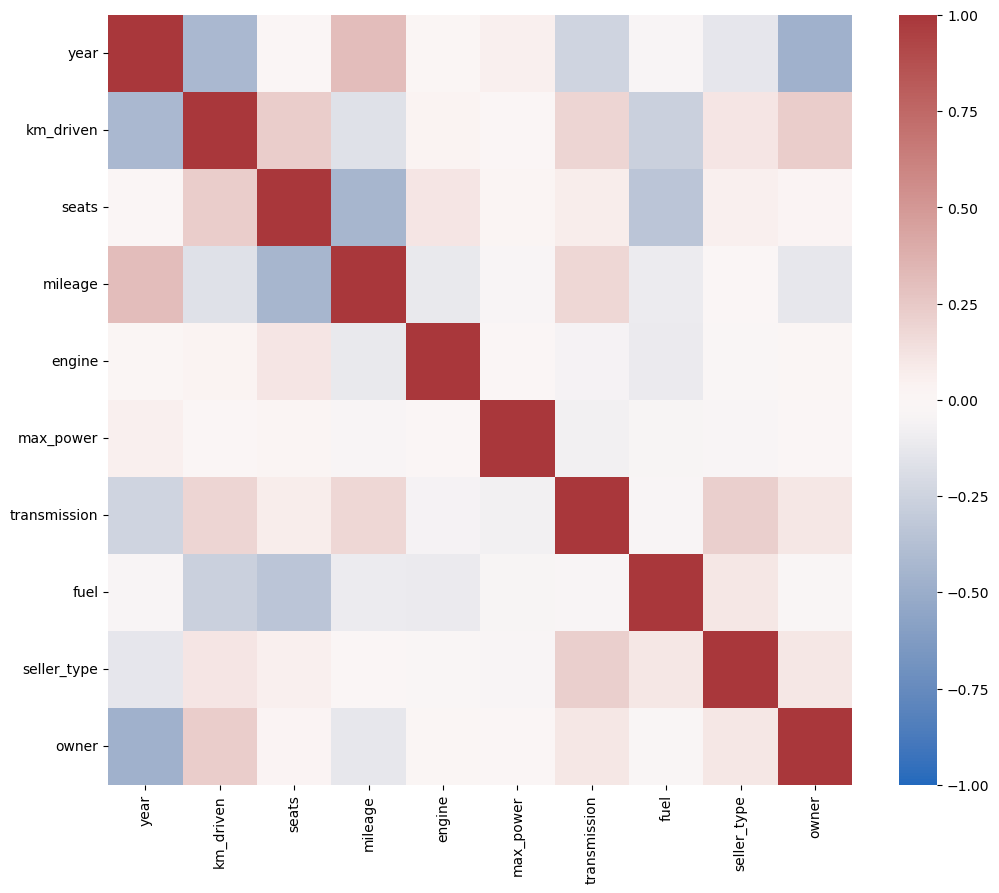

In [362]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_vehiculos_t[variables_interes].corr(), cmap = 'vlag', vmin = -1, vmax = 1)
plt.show()

Cambio de los valores nulos por la media de los datos por cada columna

In [374]:
df_vehiculos_copy = df_vehiculos_t.copy()

In [375]:
def fill_na_all(df, var_to_transform):
    for i in var_to_transform:
        mean = df[i].mean()
        df[i]=df[i].fillna(mean)
    mean = df['selling_price'].mean()
    df['selling_price']=df['selling_price'].fillna(mean)
    return df
        

In [376]:
df_vehiculos_copy= fill_na_all(df_vehiculos_copy,variables_interes)

In [377]:
df_vehiculos_copy.sample(5)
df_vehiculos_copy[['selling_price'] + variables_interes].isnull().sum() / df_vehiculos_copy.shape[0]
#Se muestra que se ha pasado los nulos a valores promedio

selling_price    0.0
year             0.0
km_driven        0.0
seats            0.0
mileage          0.0
engine           0.0
max_power        0.0
transmission     0.0
fuel             0.0
seller_type      0.0
owner            0.0
dtype: float64

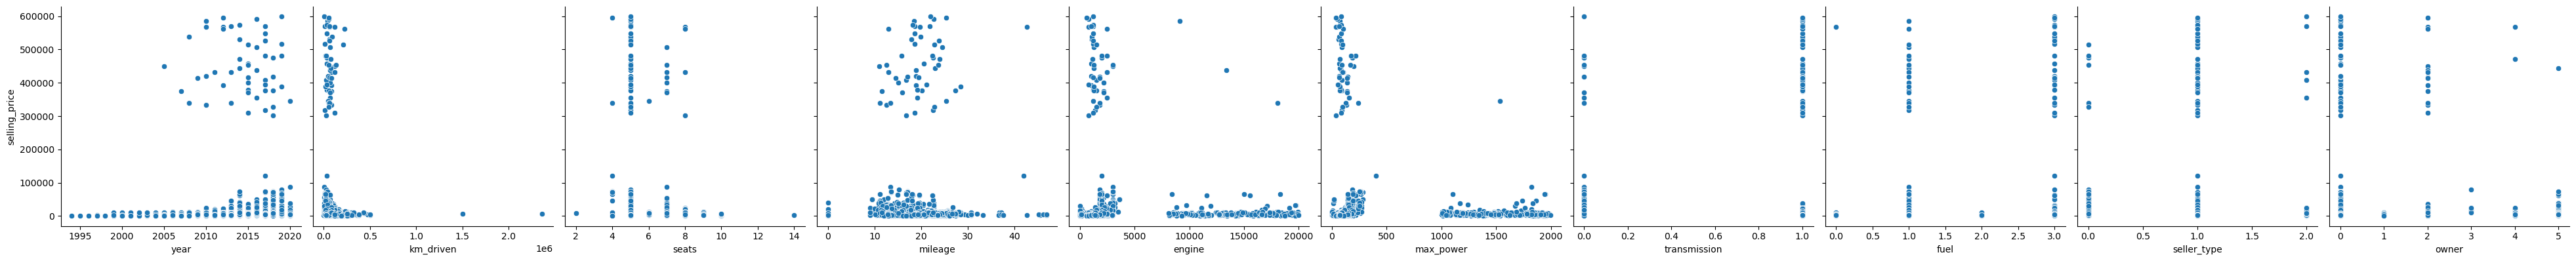

In [378]:
sns.pairplot(df_vehiculos_copy, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

## 3.Particionamiento del conjunto de datos.
Separación datos x y y para entrenamiento y x y y para test.

In [379]:
X_train, y_train  = df_vehiculos_copy[variables_interes], df_vehiculos_copy['selling_price']
X_train.shape, y_train.shape

((7115, 10), (7115,))

In [380]:
df_vehiculos_test = pd.read_csv('./data/MotorAlpes_test.csv', sep=',', encoding = 'utf-8')
X_test = df_vehiculos_test[variables_interes]
X_test.shape

(791, 10)

## 4. Entrenamiento de un primer modelo
Para este primer modelo solo se va a remplazar los valores nulos a la media  de todos los datos.

In [381]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

### 4.1 Interpretaicón de los coeficientes y del intercepto

In [382]:
pd.DataFrame({'columns': variables_interes, 'coef': regression.coef_})

,columns,coef
0,year,716.464054
1,km_driven,-0.012672
2,seats,62.669241
3,mileage,-275.140056
4,engine,0.326733
5,max_power,-0.071371
6,transmission,-14045.349786
7,fuel,-1462.933874
8,seller_type,-1628.719176
9,owner,-196.974857


In [383]:
regression.intercept_

-1409787.056722158

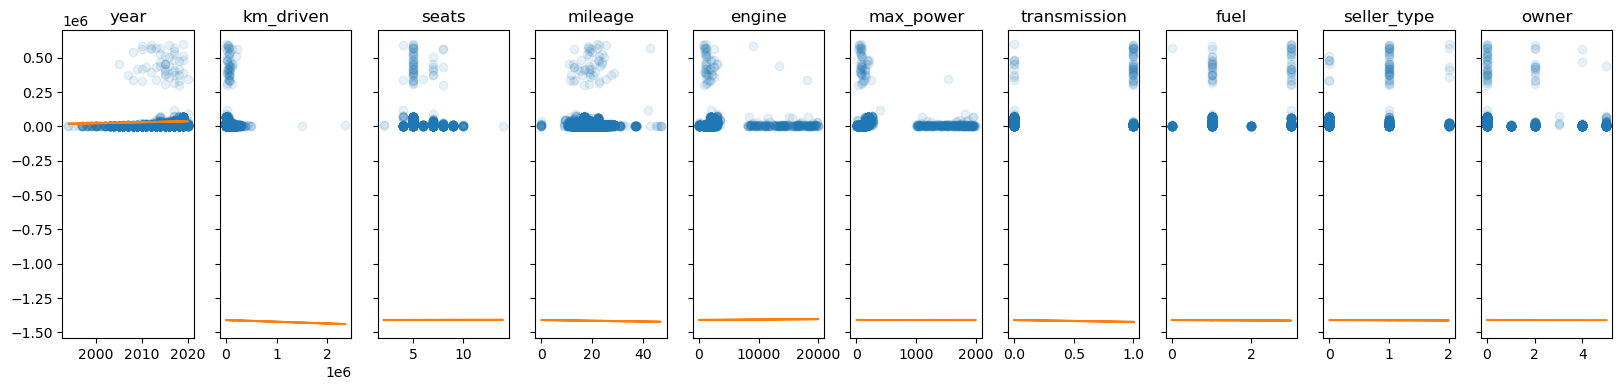

In [384]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

## 4.2 Validación del modelo
### Mean Absolute Error

## 5. Entrenamiento 2do Modelo


In [385]:
def fill_outliers(df, var_to_transform):
    """for i in var_to_transform:

            q_low = df[i].quantile(0.01)
            q_hi  = df[i].quantile(0.99)
            mean = df[i].mean()


            df = df.mask(df[i]>q_hi,mean)
            df = df.mask(df[i]<q_low,mean)"""

    
    
    q_low = df['selling_price'].quantile(0.25)
    q_hi  = df['selling_price'].quantile(0.75)
    iqr=q_hi-q_low
    maximus = q_hi-1.5*iqr
    minimus = q_low-1.5*iqr

    mean = df['selling_price'].mean()



    df = df.mask(df['selling_price']>maximus,mean)
    df = df.mask(df['selling_price']<minimus,mean)
    return df
        
 

In [394]:
df_vehiculos_transformed=fill_outliers(df_vehiculos_copy,variables_interes)

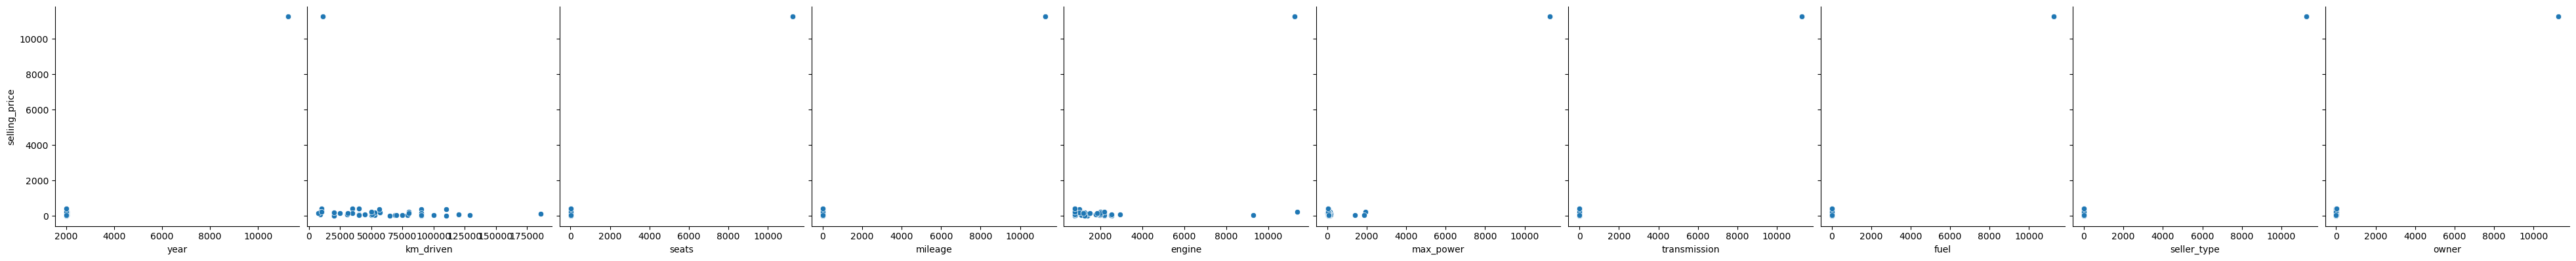

In [395]:
sns.pairplot(df_vehiculos_transformed, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

In [396]:
X_train, y_train  = df_vehiculos_transformed[variables_interes], df_vehiculos_transformed['selling_price']
X_train.shape, y_train.shape

((7115, 10), (7115,))

In [401]:
regression_2 = LinearRegression()
regression_2.fit(X_train, y_train)

LinearRegression()

pd.DataFrame({'columns': variables_interes, 'coef': regression.coef_})

In [399]:
regression_2.intercept_

18457.47383055438

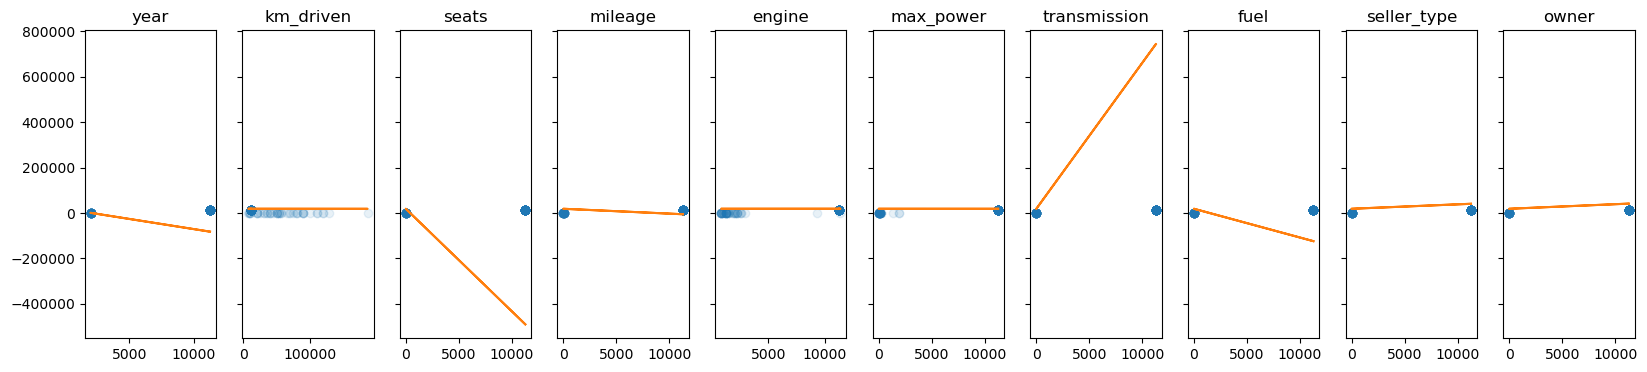

In [400]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = X_train[col]
    m = regression_2.coef_[i]
    b = regression_2.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

## 6. Entrenamiento 3r Modelo

Para este segundo modelo se va a aplicar metodos de normalización con tal 

In [388]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [389]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [391]:
pd.DataFrame({'columns': variables_interes, 'coef': pipeline['model'].coef_})

,columns,coef
0,year,2713.271491
1,km_driven,-724.213023
2,seats,59.754352
3,mileage,-1150.590855
4,engine,756.965515
5,max_power,-19.249306
6,transmission,-4773.080927
7,fuel,-1466.381316
8,seller_type,-650.754510
9,owner,-277.016263


In [392]:
pipeline['model'].intercept_

11261.208041405842

In [ ]:
year_prep = year.fillna(mean_year)

In [12]:
year = df_vehiculos_copy['year']
mean_year = year.mean()
print(year)
print(mean_year)

1       2014.0
2       2006.0
4       2007.0
5       2017.0
6       2007.0
         ...  
7108    2013.0
7111    2007.0
7112    2009.0
7113    2013.0
7114    2013.0
Name: year, Length: 6045, dtype: float64
2013.975682382134


In [ ]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x="year", data=df_vehiculos_copy, orient="h")

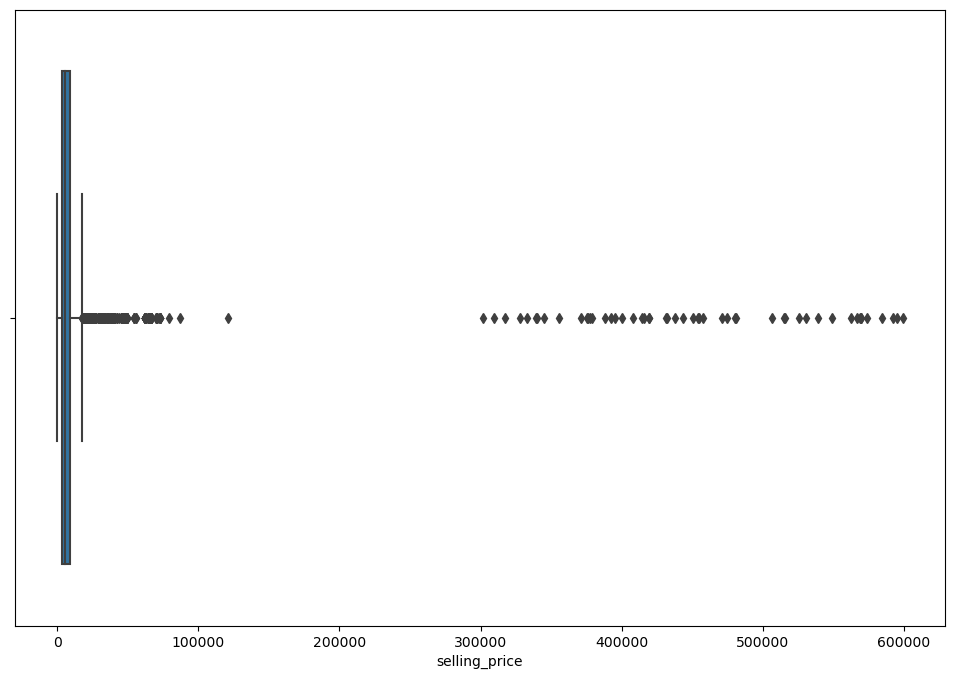

In [312]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x='selling_price', data= df_vehiculos_copy, orient="h")
plt.show()

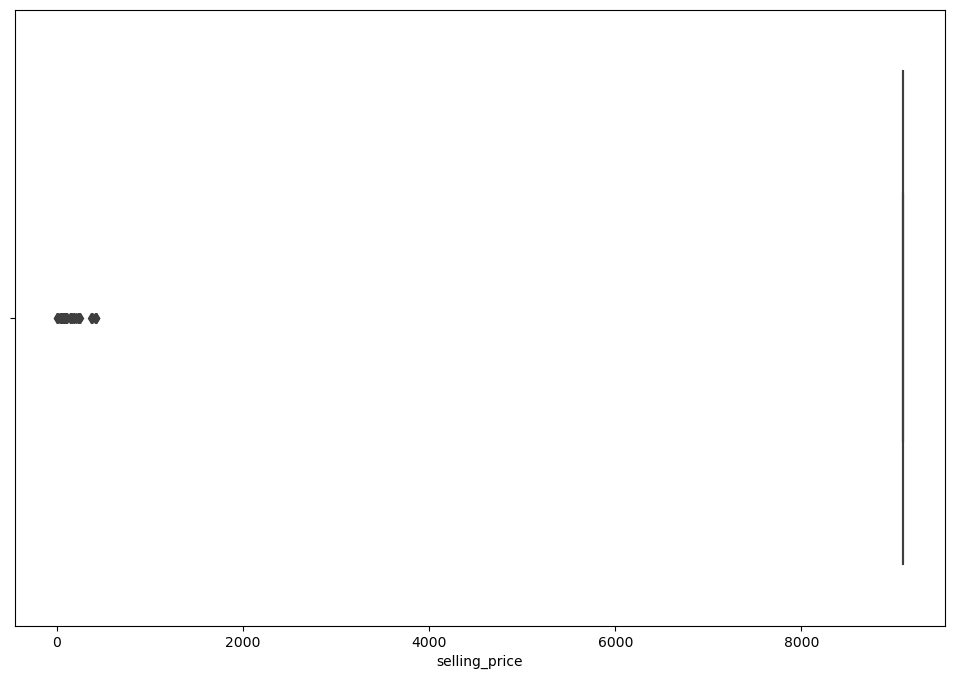

In [313]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x='selling_price', data= df_vehiculos_transformed, orient="h")
plt.show()

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x="year", data=df_vehiculos, orient="h")

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x="seats", data=df_vehiculos, orient="h")

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x="mileage", data=df_vehiculos, orient="h")

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x="engine", data=df_vehiculos, orient="h")

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot(x="max_power", data=df_vehiculos, orient="h")